In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from tqdm.notebook import tqdm
import os
import seaborn as sns
import random
import math
import scipy as sp
import itertools
sns.set(style="whitegrid")

Load and check data:

In [2]:
alldata = pd.read_csv("error_data.csv")

In [3]:
alldata.head()

,participant,phase,condition,cue,target,response,rt,correct,Column1,Column2
0,1001.0,learn,1.0,EMPIRE,STATE,KING,3457.0,2.0,NaN,NaN
1,1001.0,learn,1.0,CHUNK,BLOCK,HUNK,3361.0,2.0,NaN,NaN
2,1001.0,learn,1.0,GLIDE,HANG,FLY,2177.0,2.0,NaN,NaN
3,1001.0,learn,1.0,SAIL,OCEAN,BOAT,2341.0,2.0,NaN,NaN
4,1001.0,learn,1.0,ELEVATOR,BUILDING,UP,3464.0,2.0,NaN,NaN


In [4]:
alldata.shape

(5670, 10)

# Log likelihood

Implement ACT-R code:

In [4]:
def activation(traces, time, decay):
    """Computes the activation of a memory given its history of retrievals"""
    ftraces = [x for x in traces if x < time]
    decay = max(0, decay)  # Allows no positive decay rates in equation 
    decay - min(decay, 5)
    times = time - np.array(ftraces)
    odds = times ** -decay
    return np.log(np.sum(odds))

activation([5, 10, 15], 40, 0.5)

-0.5949230018850301

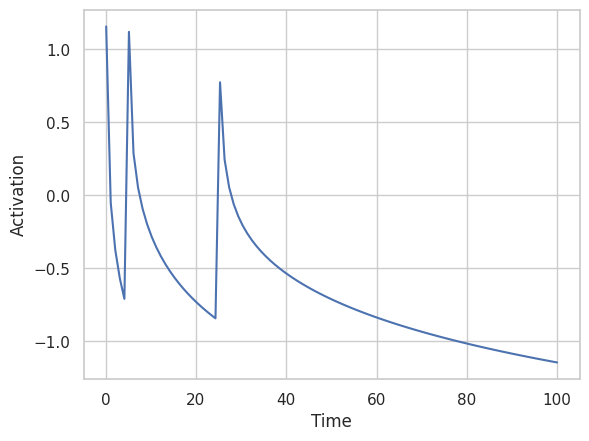

In [5]:
time = np.linspace(0.1, 100, 100)
traces = [0.001, 5, 25]
y = []
for t in time:
    act = activation(traces, t, 0.5)
    y += [act]
    
plt.plot(time, y)
plt.xlabel("Time")
plt.ylabel("Activation")
plt.show()

Create loglikelihood function for the model

In [6]:
def boltzmann(options, values, temperature):
    """Returns a Boltzmann distribution of the probabilities of each option"""
    temperature = max(temperature, 0.01) 
    vals = np.array(values)/temperature
    #bvals = np.exp(vals)/np.sum(np.exp(vals))
    bvals = np.exp(vals - np.max(vals)) / np.exp(vals - np.max(vals)).sum()
    return dict(zip(options, bvals))

In [7]:
boltzmann([2,3], [1, 0.7], 1)

{2: 0.574442516811659, 3: 0.425557483188341}

Create a loglikelihood function for the elaborative model, each error item is given additional spreading activation given the max association (mas) parameter

### Complete *elaborative* model

In [9]:
def LLelab(data, decay, temp, mas):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    # since we don't have data for when study items were presented in each participant's learning phase
    # we will use the presentation of the error items and interleaven the study items in between
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase


    # model testing phase
    LL = 0
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
      # Calculate log likelihood of response- possible options are 19 random integers
      # or correct associate
      options = DM[cue].keys()
      # create spreading activation additional error component given size of cue's dec mem
      cueMem = len(DM[cue])
      add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
      # if error condition, add spreading activation
      values = [activation(DM[cue][opt], time, decay) if condition == 1 else 
       (activation(DM[cue][opt], time, decay) + add) for opt in options]
      prob = boltzmann(options, values, temp)[response]
    
      # Sum up the LLs
      LL += np.log(max(prob, 10e-10))

       # add time taken to responde
      time += rt/1000
    
    return LL

In [10]:
LLelab(alldata[alldata.participant == 1001], 0.5, 1, 1.6)

-174.4412782790136

In [11]:
LLelab(alldata[alldata.participant == 1002], 0.5, 1, 4)

-177.46115123650327

Create a loglikelihood function of the mediator model, where there are two routes to make a decision: To remember something that worked and to remember something that did not.

In [12]:
def LLmed(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase

    # model testing phase
    LL = 0
    
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
        # Calculate log likelihood of response- possible options are 19 random integers
        # or correct associate
        options = DM[cue].keys()
        # create spreading activation additional error component given size of cue's dec mem
        cueMem = len(DM[cue])
        # if error condition, add spreading activation
        values = [activation(DM[cue][opt], time, decay) for opt in options]
        prob1 = boltzmann(options, values, temp)[response]
        
        # probability of retrieving error memory
        if condition == 1:
          error = errorResp[cue]
          prob2 = boltzmann(options, values, temp)[error]
        else:
          prob2 = 0
        
        # Sum up the LLs
        LL += np.log(max(prob1 + prob2, 10e-10))
        
         # add time taken to responde
        time += rt/1000
        
    return LL

In [13]:
LLmed(alldata[alldata.participant == 1001], 0.5, 1)

-148.38513809212435

In [14]:
LLmed(alldata[alldata.participant == 1002], 0.5, 1)

-150.88790456104599

# Create RT models

In [39]:
def responsetime(activation, ter=1, F=1, f=1):
    return ter + F * np.exp(-f * activation)

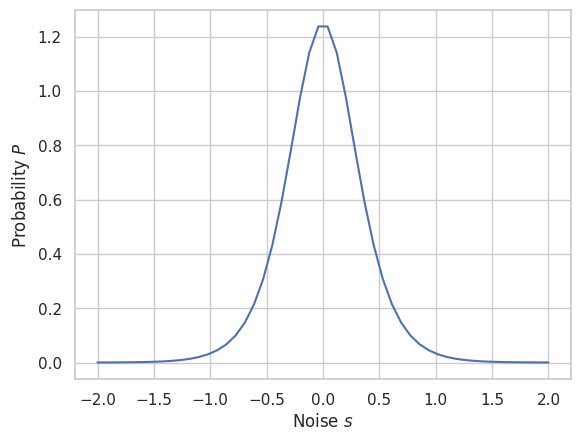

In [9]:
noise = np.linspace(-2, 2)
dist = sp.stats.logistic(0, 0.2)
plt.plot(noise, dist.pdf(noise))
plt.xlabel("Noise $s$")
plt.ylabel("Probability $P$")
plt.show()

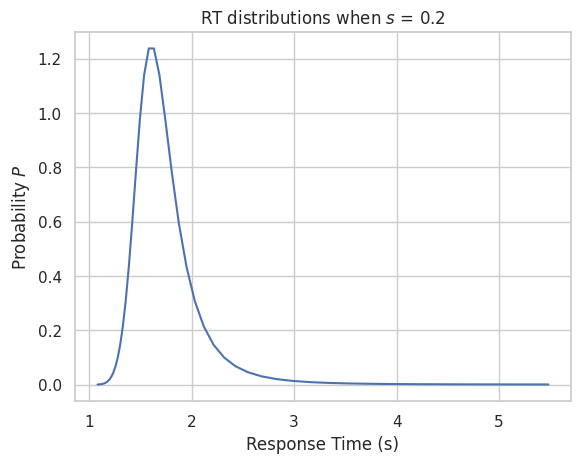

In [10]:
rts = [responsetime(0.5 - x) for x in noise]
plt.plot(rts, dist.pdf(noise))
plt.xlabel("Response Time (s)")
plt.ylabel("Probability $P$")
plt.title("RT distributions when $s$ = 0.2")
plt.show()

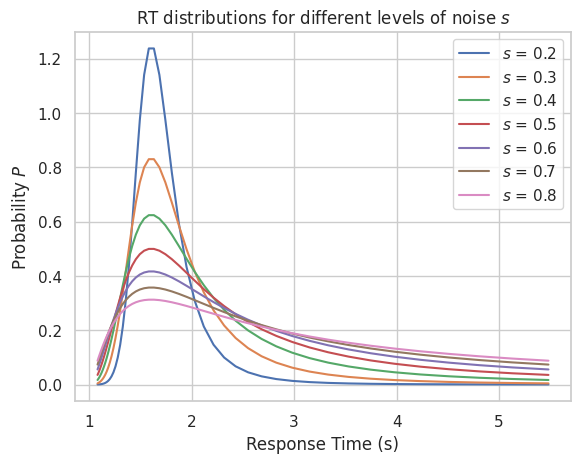

In [11]:
for s in np.linspace(0.2, 0.8, 7):
    dist = sp.stats.logistic(0, s)
    rts = [responsetime(0.5 - x) for x in noise]
    plt.plot(rts, dist.pdf(noise))
plt.legend(["$s$ = %.1f" % (x,) for x in np.linspace(0.2, 0.8, 7)])
plt.xlabel("Response Time (s)")
plt.ylabel("Probability $P$")
plt.title("RT distributions for different levels of noise $s$")
plt.show()

In [12]:
from urllib.request import proxy_bypass
def rtProb(rt, activation, s):
  """Takes one parameter for noise, s, and outputs a probability distribution for response times"""
  noise = np.linspace(-2, 2)
  dist = sp.stats.logistic(0, s)
  rts = [responsetime(activation - x) for x in noise]
  prob = dist.pdf(noise)
  rtprob = {rts[i]:prob[i]for i in range(len(noise))}
  val = min(rtprob.keys(), key=lambda x: abs(x - (rt/1000)))
  return rtprob[val]

In [14]:
rtProb(5030, 3, 1)

0.10499358540350652

## Elaborative Model

In [40]:
def LLelabRT(data, decay, temp, mas):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase


    # model testing phase
    LL = 0
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
      # Calculate log likelihood of response- possible options are 19 random integers
      # or correct associate
      options = DM[cue].keys()
      # create spreading activation additional error component given size of cue's dec mem
      cueMem = len(DM[cue])
      add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
      # if error condition, add spreading activation
      values = [(activation(DM[cue][opt], time, decay) + add) if condition == 1 else 
       activation(DM[cue][opt], time, decay) for opt in options]
      prob = boltzmann(options, values, temp)[response]
    
      # now calculate response times:
      if condition == 1:
        resp_activation = activation(DM[cue][response], time, decay) + add
      else: 
        resp_activation = activation(DM[cue][response], time, decay)

      
      prob_rt = rtProb(rt, resp_activation, temp)

      # Sum up the LLs
      LL += (np.log(max(prob, 10e-10)) + np.log(max(prob_rt, 10e-10)))

       # add time taken to responde
      time += rt/1000
    
    return LL

In [41]:
LLelabRT(alldata[alldata.participant == 1001], 0.5, 1, 1.6)

-285.74816151819357

In [42]:
LLelabRT(alldata[alldata.participant == 1002], 0.5, 1, 1.6)

-298.7803561094662

## Mediator Model

In [43]:
from urllib.request import proxy_bypass
def rtProb2(rt, resp_activation, error_activation, condition, s):
  """Takes one parameter for noise, s, and outputs a probability distribution for response times"""
  noise = np.linspace(-2, 2)
  dist = sp.stats.logistic(0, s)
  if condition == 1:
    rts = [(responsetime(resp_activation - x) + responsetime(error_activation - x)) for x in noise]
  else: 
    rts = [responsetime(resp_activation - x) for x in noise]
  prob = dist.pdf(noise)
  rtprob = {rts[i]:prob[i]for i in range(len(noise))}
  val = min(rtprob.keys(), key=lambda x: abs(x - (rt/1000)))
  return rtprob[val]

In [32]:
rtProb2(6100, 3, 2, 1, 0.2)

{6.02505358588782: 0.00022697903867975835, 6.027184572355142: 0.00034137281274882006, 6.029496814445681: 0.0005134073611775754, 6.032005729245116: 0.0007721117937022627, 6.034728045172405: 0.001161116038046361, 6.037681913518051: 0.0017459708526843518, 6.040887029469488: 0.002625107669818369, 6.0443647634305515: 0.003946210267652735, 6.048138303510593: 0.0059305849349991484, 6.052232810133328: 0.008909243372586471, 6.056675583796256: 0.013375890766102105, 6.061496247099234: 0.020063753257978992, 6.066726942255862: 0.030054746763942285, 6.072402545404637: 0.04492959053532246, 6.078560899148801: 0.06696292135023516, 6.08524306487535: 0.09935129227210873, 6.092493596535601: 0.14642056338366785, 6.100360837712727: 0.21367047593847505, 6.1088972439570295: 0.30735433166195114, 6.118159732538112: 0.4330732629625037, 6.128210061945989: 0.5927437358626545, 6.139115243671464: 0.7797410889003382, 6.150947989011373: 0.9737525582511741, 6.163787193877816: 1.139808944540161, 6.177718464843861: 1.237

0.21367047593847505

In [44]:
def LLmedRT(data, decay, temp):
    """For each trial, calculate the probability of that response, sum the log likelihoods, and update the values"""
    # create a list of error items
    errors = data[data.phase == "learn"].cue.tolist()
    # create a list of study items
    study = data[data.condition == 2].cue.tolist()
    pos = 1
    present = errors[:]
    for i in range(len(errors)):
      word = study[i]
      present.insert(pos, word)
      pos += 2

    # Create dict with word pairs
    pairs = {}
    for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
      pairs[cue] = target
    # also create a dict with errors
    errorResp = dict()
    for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
      errorResp[cue] = response

    # model learning phase, encode a single trace for each item: (idk what to set activation at)
    DM = dict()
    # for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
    # possible responses and their activation
    time = 0
    step = 10 #time for learning each item
    for cue in present:
      littleDM = {}
      # make a set of all reponses given to a certain cue to be "vocab for that cue"
      for response in set(alldata[alldata.cue == cue].response):
        littleDM[response] = [0.001]
      # add retrieval of error for error items
      if cue in errorResp.keys():
        error = errorResp[cue]
        time +=5
        littleDM[error] = [0.001, time]
      # overwrite smaller activ of correct target to show task learning
        time +=5
        littleDM[pairs[cue]] = [0.001, time]
      else:
        time += 10
        littleDM[pairs[cue]] = [0.001, time]
      DM[cue] = littleDM
    time += 300 # time for distractor phase

    # model testing phase
    LL = 0
    
    for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                   data[data.phase == "test"].cue, 
                                   data[data.phase == "test"].response, 
                                   data[data.phase == "test"].rt, 
                                   data[data.phase == "test"].correct):
        # Calculate log likelihood of response- possible options are 19 random integers
        # or correct associate
        options = DM[cue].keys()

        # calculate probability of retrieving given response
        values = [activation(DM[cue][opt], time, decay) for opt in options]
        prob1 = boltzmann(options, values, temp)[response]
        
        # probability of retrieving error memory
        if condition == 1:
          error = errorResp[cue]
          prob2 = boltzmann(options, values, temp)[error]
        else:
          prob2 = 0
        
        # add response times calculations
        # probability of given response time with
        respAct = activation(DM[cue][response], time, decay)
        if condition == 1:
          error = errorResp[cue]
          errorAct = activation(DM[cue][error], time, decay)
          prob_rt = rtProb2(rt, respAct, errorAct, condition, temp)
        else:
          errorAct = 0
          prob_rt = rtProb2(rt, respAct, errorAct, condition, temp)

        # Sum up the LLs
        LL += (np.log(max(prob1 + prob2, 10e-10)) + np.log(max(prob_rt, 10e-10)))
        
         # add time taken to responde
        time += rt/1000
        
    return LL

In [45]:
LLmedRT(alldata[alldata.participant == 1001], 0.5, 1)

-268.76677051236334

In [46]:
LLmedRT(alldata[alldata.participant == 1002], 0.5, 1)

-283.26348176311467

# Calculate LL for each ppt and assign best model

In [58]:
df = pd.DataFrame(columns = ['participant', 'LLelab', 'LLmed', 'LLdiff', 'best'])
participant = alldata.participant.unique().tolist()
LLelab = []
LLmed = []
for ppt in participant:
  data = alldata[alldata.participant == ppt]
  LLelab.append(LLelabRT(data, 0.5, 1, 1.6))
  LLmed.append(LLmedRT(data, 0.5, 1))

In [67]:
df['participant'] = participant
df['LLelab'] = LLelab
df['LLmed'] = LLmed
df['LLdiff'] = df['LLelab'] - df['LLmed']
df['best'] = np.where(df['LLdiff'] < 0, "LLmed", "LLelab")
df.dropna()

,participant,LLelab,LLmed,LLdiff,best
0,1001.0,-285.748162,-268.766771,-16.981391,LLmed
1,1002.0,-298.780356,-283.263482,-15.516874,LLmed
2,1003.0,-287.876550,-276.624213,-11.252338,LLmed
3,1004.0,-304.429272,-283.812424,-20.616848,LLmed
4,1005.0,-286.645274,-272.467672,-14.177602,LLmed
...,...,...,...,...,...
56,1064.0,-273.335817,-263.454363,-9.881453,LLmed
57,1065.0,-275.177037,-266.183760,-8.993276,LLmed
58,1067.0,-318.738163,-291.629524,-27.108639,LLmed
59,1068.0,-276.007230,-262.540341,-13.466889,LLmed


### Walk through of *elaborative* model using ppt 1001's data

In [35]:
# create a list of error items
data = alldata[alldata.participant == 1001]
errors = data[data.phase == "learn"].cue.tolist()
# create a list of study items
study = data[data.condition == 2].cue.tolist()
# since we don't have data for when study items were presented in each participant's learning phase
# we will use the presentation of the error items and interleaven the study items in between
pos = 1
present = errors[:]
for i in range(len(errors)):
  word = study[i]
  present.insert(pos, word)
  pos += 2

# Create dict with word pairs
pairs = {}
for cue, target in zip(data[data.phase == "test"].cue,data[data.phase == "test"].target):
  pairs[cue] = target
# also create a dict with errors
errorResp = dict()
for cue,response in zip(data[data.phase == "learn"].cue,data[data.phase == "learn"].response):
  errorResp[cue] = response

print("First 5 key,value pairs in word pair dictionary:", dict(itertools.islice(pairs.items(), 5)))
print("First 5 key,value pairs in error response dictionary:", dict(itertools.islice(errorResp.items(), 5)))

First 5 key,value pairs in word pair dictionary: {'HONEYMOON': 'ROMANCE', 'TASTY': 'TREAT', 'SWING': 'TREE', 'DIAMETER': 'LENGTH', 'CANYON': 'MOUNTAIN'}
First 5 key,value pairs in error response dictionary: {'EMPIRE': 'KING', 'CHUNK': 'HUNK', 'GLIDE': 'FLY', 'SAIL': 'BOAT', 'ELEVATOR': 'UP'}


In [37]:
# model learning phase, encode a single trace for each item:
DM = dict()
# for DM can we make a dictionary of dictionaries where big keys are cues, values are dictionary of target/
# possible responses and their activation
time = 0
step = 10 #time for learning each item
for cue in present:
  littleDM = {}
# make a set of all reponses given to a certain cue to be "vocab for that cue"
  for response in set(alldata[alldata.cue == cue].response):
    littleDM[response] = [0.001]
    # add retrieval of error for error items
  if cue in errorResp.keys():
    error = errorResp[cue]
    time +=5
    littleDM[error] = [0.001, time]
    # overwrite smaller activ of correct target to show task learning
    time +=5
    littleDM[pairs[cue]] = [0.001, time]
  else:
    time += 10
    littleDM[pairs[cue]] = [0.001, time]
  DM[cue] = littleDM
time += 300 # time for distractor phase

print("First 5 key,value pairs in declarative memory dictionary:", dict(itertools.islice(DM.items(), 5)))

First 5 key,value pairs in declarative memory dictionary: {'EMPIRE': {nan: [0.001], 'FALL': [0.001], 'PEOPLE': [0.001], 'ROME': [0.001], 'RULER': [0.001], 'legend': [0.001], 'STRIKES BACK': [0.001], 'building': [0.001], ' STATE': [0.001], 'STA': [0.001], 'KING': [0.001, 5], 'STATES': [0.001], 'BIG': [0.001], 'NATION': [0.001], 'BULDING': [0.001], 'STRIKE': [0.001], 'clro': [0.001], 'KINGDOM': [0.001], 'NEW YORK': [0.001], 'OF THE DEAD': [0.001], 'STATE': [0.001, 10], 'EMPEROR': [0.001], 'COUNTRY  ': [0.001], 'BUISNE': [0.001], 'CITY': [0.001], 'BUILDING': [0.001], 'state': [0.001], 'IDK': [0.001], 'dynasty': [0.001], 'BUIDLING': [0.001], 'LOGICAL': [0.001], ' LAW': [0.001], 'R': [0.001]}, 'TASTY': {'SWEET': [0.001], nan: [0.001], 'food': [0.001], 'yummy': [0.001], 'FOOD': [0.001], 'YUMMY': [0.001], 'SCARY': [0.001], 'NICE': [0.001], 'NOODLES': [0.001], 'COOKIE': [0.001], 'DELICIOUS': [0.001], 'treat': [0.001], 'CANDY': [0.001], 'EAT': [0.001], 'GOOD': [0.001], 'TREAT': [0.001, 20]}, 'C

In [131]:
# model testing phase
LL = 0
mas = 1.6
decay = 0.5
temp = 1
s = 1
for condition, cue, response, rt, feedback in zip(data[data.phase == "test"].condition,
                                data[data.phase == "test"].cue, 
                                data[data.phase == "test"].response, 
                                data[data.phase == "test"].rt, 
                                data[data.phase == "test"].correct):
  # Calculate log likelihood of response- possible options are 19 random integers
  # or correct associate
  options = DM[cue].keys()
  # create spreading activation additional error component given size of cue's dec mem
  cueMem = len(DM[cue])
  add = (mas - np.log((cueMem + 1)/2)) - (mas - np.log((cueMem + 1)/1))
  # if error condition, add spreading activation
  values = [(activation(DM[cue][opt], time, decay) + add) if condition == 1 else 
    activation(DM[cue][opt], time, decay) for opt in options]
  prob = boltzmann(options, values, temp)[response]
  print(response, ":", prob)
    
  # now calculate response times:
  if condition == 1:
    resp_activation = activation(DM[cue][response], time, decay) + add
  else: 
    resp_activation = activation(DM[cue][response], time, decay)
    
  prob_rt = rtProb(rt, resp_activation, s)
  print(rt, ":", prob_rt)

  # Sum up the LLs
  LL += (np.log(max(prob, 10e-10)) + np.log(max(prob_rt, 10e-10)))

  # add time taken to responde
  time += rt/1000

 ROMANCE : 0.026196178655054057
4347.0 : 0.10499358540350652
FOOD : 0.05881304697545754
6643.0 : 0.10499358540350652
SET : 0.01921851046794527
21190.0 : 0.23781259172552724
LENGTH : 0.06661411205502198
4883.0 : 0.10499358540350652
MOUNTAIN : 0.046202678862480515
5486.0 : 0.12567665063718317
COMPUTER : 0.04760540569517234
11181.0 : 0.1116485398880558
CHEMISTRY : 0.18248982445306108
3558.0 : 0.10499358540350652
AGENT : 0.03224548708249142
9548.0 : 0.10499358540350652
RUN : 0.03702409698661163
2925.0 : 0.10499358540350652
MEDICINE : 0.05964510555423817
23782.0 : 0.2417521362684043
STOP : 0.041640609402490904
8305.0 : 0.10499358540350652
JOB : 0.015825189750031263
30862.0 : 0.24989590562229985
TASTY : 0.03223945649853816
7778.0 : 0.10499358540350652
MATH : 0.04994775361963636
17232.0 : 0.1559482177800677
RED : 0.08867384019288146
1826.0 : 0.10499358540350652
MEET : 0.04602674509044879
6929.0 : 0.16378218370563144
LEAVE : 0.07489062303869433
10464.0 : 0.16378218370563144
SPANISH : 0.0232083